In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import dill as pickle

# Data Preprocessing

In [2]:
# fetch the data
bitcoin = yf.Ticker("BTC-USD")
bitcoin

yfinance.Ticker object <BTC-USD>

In [3]:
#Get historical data
bitcoin_data = bitcoin.history(start ="2015-01-01", end=date.today(), interval="1d")

bitcoin_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-12,37340.144531,37408.925781,34728.191406,35552.515625,37924228550,0,0
2021-06-13,35555.789062,39322.781250,34864.109375,39097.859375,40669112838,0,0
2021-06-14,39016.968750,40978.363281,38757.285156,40218.476562,43148914673,0,0
2021-06-15,40427.167969,41295.269531,39609.468750,40406.269531,46420149185,0,0
2021-06-16,40168.691406,40516.777344,38176.035156,38347.062500,39211635100,0,0


### Data Visualization

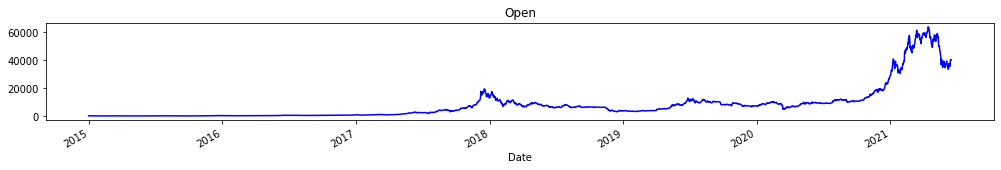

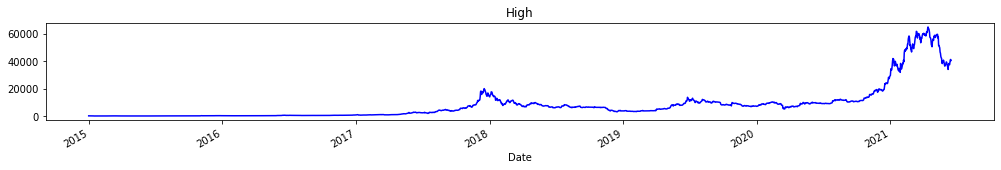

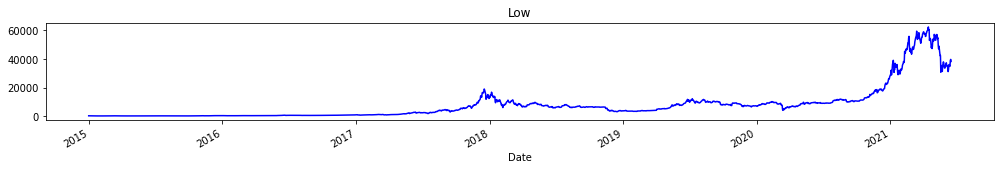

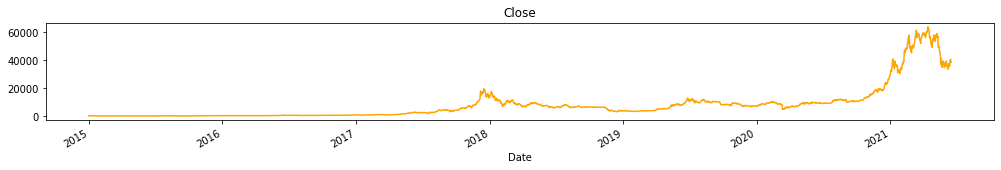

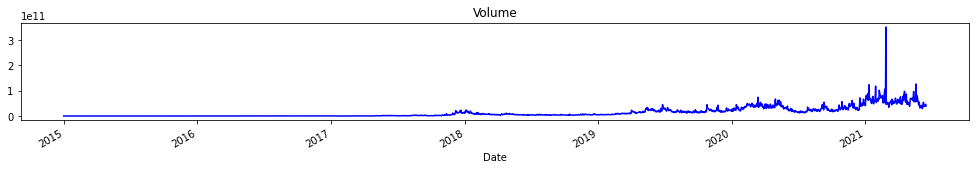

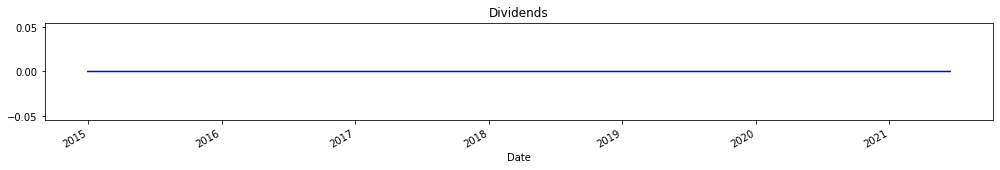

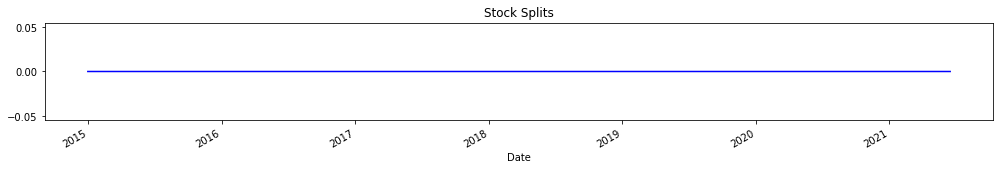

In [4]:
%matplotlib inline

for col in bitcoin_data.columns:
    color="orange" if col == "Close" else "blue"
    bitcoin_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
bitcoin_data = bitcoin_data.reset_index()
bitcoin_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-12-31,310.914001,320.192993,310.210999,320.192993,13942900,0,0
1,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,0,0
2,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0,0
3,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,0,0
4,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,0,0


In [6]:
#check if date is in datetime format
bitcoin_data.Date.dtype

dtype('<M8[ns]')

In [7]:
#save the dataframe to csv
bitcoin_data.to_csv("bitcoin.csv")

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [8]:
#Extracting the date and close price columns
bitcoin_df = bitcoin_data[["Date", "Close"]]
bitcoin_df.head()

,Date,Close
0,2014-12-31,320.192993
1,2015-01-01,314.248993
2,2015-01-02,315.032013
3,2015-01-03,281.082001
4,2015-01-04,264.195007


In [9]:
#rename the columns
bitcoin_df = bitcoin_df.rename(columns={'Date': 'ds', 'Close': 'y'})
bitcoin_df.head()

,ds,y
0,2014-12-31,320.192993
1,2015-01-01,314.248993
2,2015-01-02,315.032013
3,2015-01-03,281.082001
4,2015-01-04,264.195007


### Splitting the Data

In [10]:
index = int(0.8 * bitcoin_df.shape[0])
train_df = bitcoin_df[:index]
test_df = bitcoin_df[index:]

In [11]:
print(train_df.shape)
print(test_df.shape)

(1884, 2)
(472, 2)


### Hyperparameter Tuning

In [12]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [13]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [14]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [15]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1915,2022-09-30,25996.061999,-177791.269461,227086.593390
1916,2022-10-31,25979.812610,-186401.549239,236905.167361
1917,2022-11-30,24795.224561,-199498.521844,246892.668939
1918,2022-12-31,25215.440909,-204702.343362,259174.717863
1919,2023-01-31,25496.576252,-213563.466332,266051.525242


## Plotting the Forecast

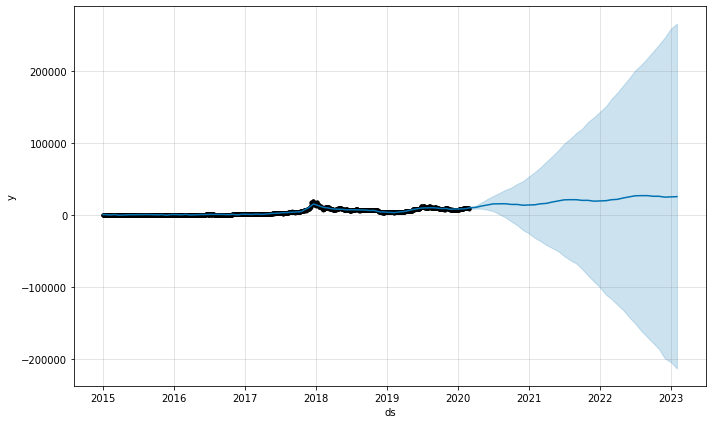

In [16]:
ax = model.plot(forecast);

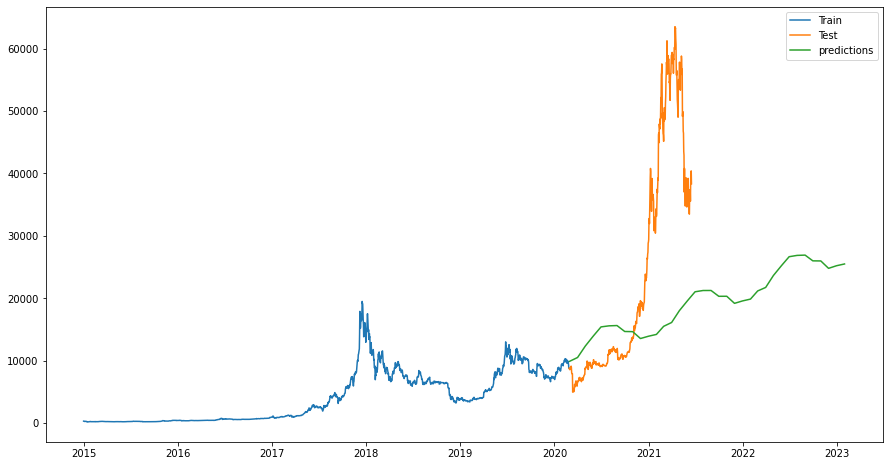

In [17]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

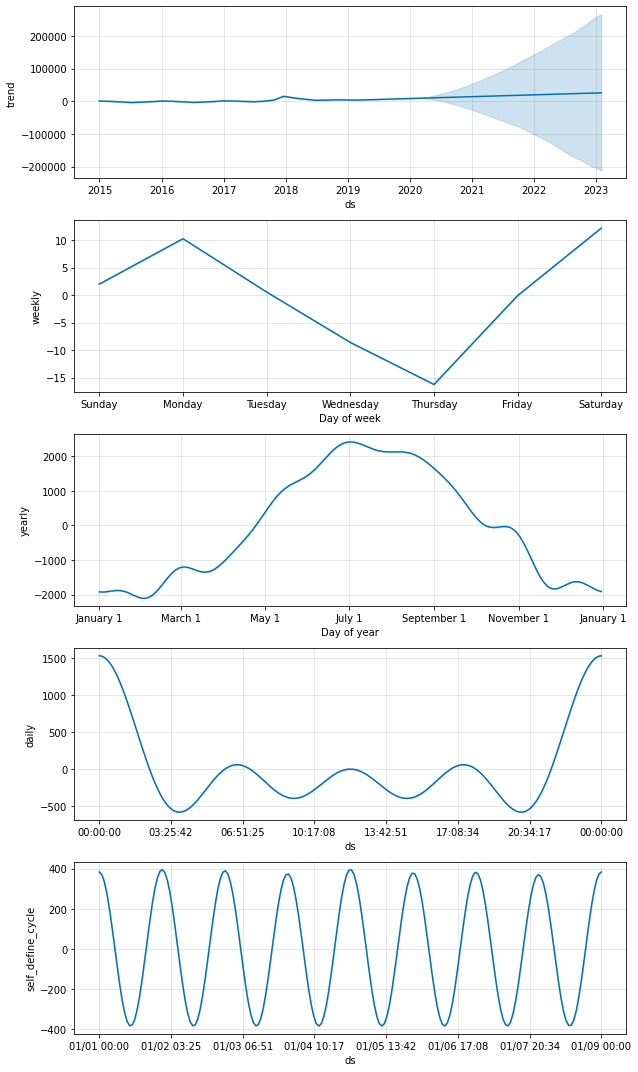

In [18]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [19]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-03 00:00:00 and 2019-02-26 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1090,2020-02-22,-2628.582414,-32236.678074,27745.843077,9663.181641,2019-02-26
1091,2020-02-23,-2601.122683,-33224.779886,27529.379641,9924.515625,2019-02-26
1092,2020-02-24,-2594.178722,-32776.068561,27932.767278,9650.174805,2019-02-26
1093,2020-02-25,-2562.216775,-31997.648097,28003.578329,9341.705078,2019-02-26
1094,2020-02-26,-2573.181086,-32597.617504,28744.494918,8820.522461,2019-02-26


In [21]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,1.566197e+06,1251.477952,1075.300993,0.190459,0.138188,0.807339
1,38 days,1.668208e+06,1291.591435,1108.728516,0.197079,0.140784,0.798165
2,39 days,1.769633e+06,1330.275454,1143.835522,0.203608,0.141885,0.788991
3,40 days,1.860175e+06,1363.882149,1173.600172,0.209011,0.144102,0.779817
4,41 days,1.949414e+06,1396.214255,1199.286494,0.213880,0.147115,0.770642


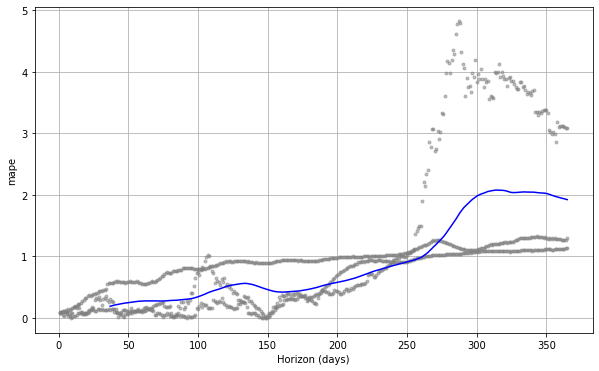

In [22]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [23]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [24]:
m.fit(train_df)

In [25]:
pickle.dump(m,open("bitcoin.pkl","wb"))

In [26]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as bitcoin:
    json.dump(model_to_json(m),bitcoin)

In [27]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1915,2022-09-30,26494.550411,-177890.403018,231514.201211
1916,2022-10-31,26784.488618,-188017.204271,239306.678290
1917,2022-11-30,25119.310511,-199255.708607,248711.671461
1918,2022-12-31,26450.882894,-207842.083185,257670.178706
1919,2023-01-31,26443.097918,-219124.279290,263663.717905


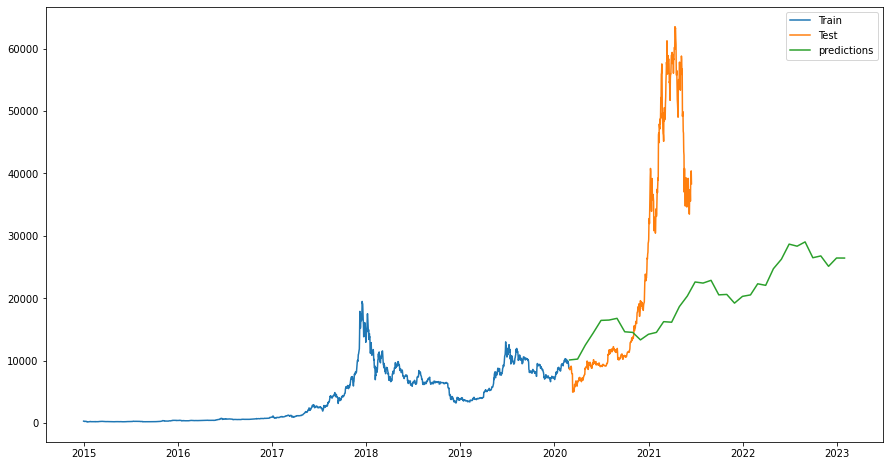

In [28]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [29]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-03 00:00:00 and 2019-02-26 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,1.507643e+06,1227.861305,1008.798273,0.163782,0.156661,0.529052
1,38 days,1.545898e+06,1243.341458,1024.817995,0.168571,0.157391,0.519878
2,39 days,1.594648e+06,1262.793750,1040.687284,0.172871,0.165272,0.510703
3,40 days,1.688030e+06,1299.242145,1073.978670,0.178946,0.168306,0.501529
4,41 days,1.795877e+06,1340.103422,1111.697957,0.185203,0.171610,0.486239


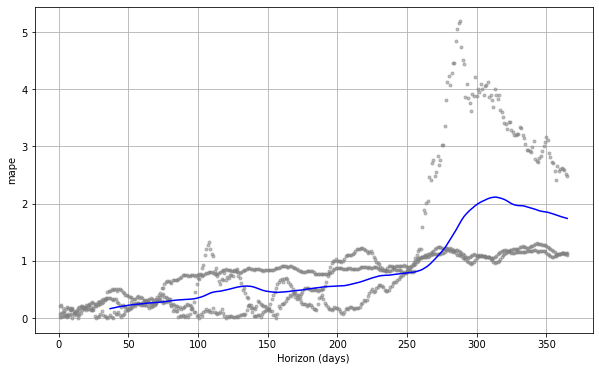

In [31]:
plot_cross_validation_metric(cv_results, metric='mape');